# CRDB Gallery

The gallery contains standard plots you can make with CRDB and the `crdb` Python library in this repository.

In [1]:
import crdb
import matplotlib.pyplot as plt
import numpy as np

## Boron to carbon ratio

We plot all data on B/C ratios in the DB and plot different experiments in different colors.

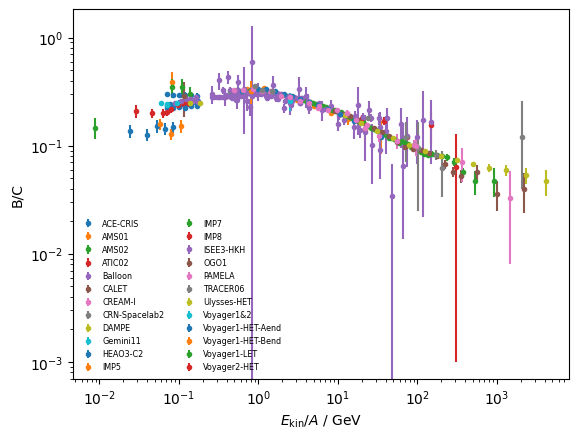

In [24]:
tab = crdb.query(num="B", den="C", energy_type="EKN")

# plot each experiment with different color
for i, (exp, mask) in enumerate(crdb.experiment_masks(tab).items()):
    t = tab[mask]
    if len(t) == 0:
        continue
    sta = ([np.abs(t["err_stat_minus"]), t["err_stat_plus"]])
    plt.errorbar(t["e_mean"], t["value"], sta, fmt=".", label=exp)

plt.legend(ncol=2, frameon=False, fontsize="xx-small")
plt.xlabel("$E_\\mathrm{kin} / A$ / GeV")
plt.ylabel("B/C")
plt.loglog();

Now we show only experiments which have published both statistical and systematic uncertainties. This is an effective way to remove old data of uncertain quality.

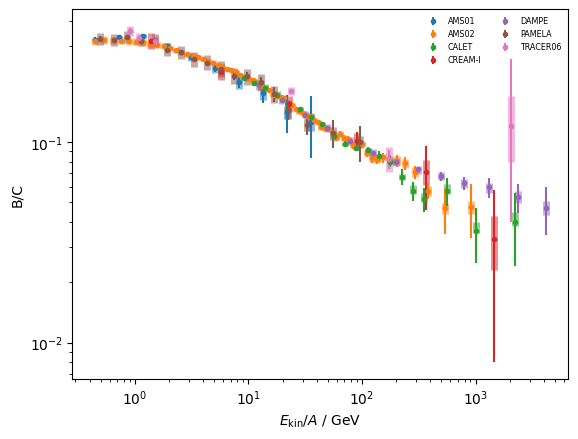

In [72]:
tab = crdb.query(num="B", den="C", energy_type="EKN")

for i, (exp, mask) in enumerate(crdb.experiment_masks(tab).items()):
    t = tab[mask]
    y = t["value"]
    sta = np.row_stack([np.abs(t["err_stat_minus"]), t["err_stat_plus"]])
    sys = np.row_stack([np.abs(t["err_sys_minus"]), t["err_sys_plus"]])
    if np.all(sys == 0):
        continue
    l = plt.errorbar(t["e_mean"], y, sta, fmt=".", label=exp)[0]
    plt.errorbar(t["e_mean"], y, sys, fmt="none",
                 lw=5, color=l.get_color(), alpha=0.5, zorder=0)

plt.legend(ncol=2, frameon=False, fontsize="xx-small")
plt.xlabel("$E_\\mathrm{kin} / A$ / GeV")
plt.ylabel("B/C")
plt.loglog();

## Electron and positron fluxes

Electron points are filled, positron points are open.

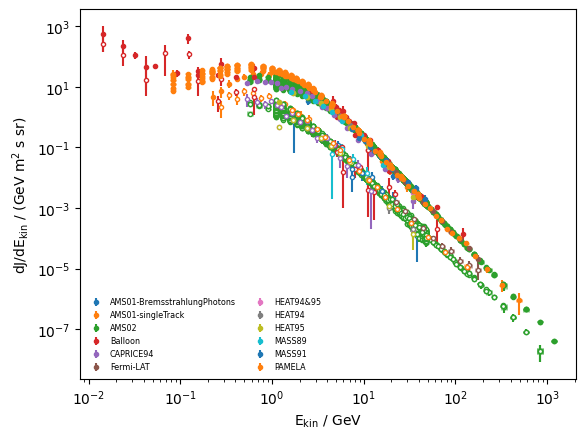

In [165]:
tab = []
for k, kind in enumerate(("e-", "e+")):
    t = crdb.query(kind, energy_type="EK", energy_convert_level=2)
    tab.append(t) 
tab = np.concatenate(tab)

plt.figure()
for iexp, (exp, mask) in enumerate(crdb.experiment_masks(tab).items()):
    t = tab[mask]
    for k, ma in enumerate((t["quantity"] == "e-", t["quantity"] == "e+")):
        t2 = t[ma]
        sta = np.row_stack([np.abs(t2["err_stat_minus"]), t2["err_stat_plus"]])
        sys = np.row_stack([np.abs(t2["err_sys_minus"]), t2["err_sys_plus"]])
        color = f"C{iexp}"
        x = t2["e_mean"]
        l = plt.errorbar(x, t2["value"], sta, fmt=".",
                         color="w" if k else color, mec=color, ecolor=color,
                         label=f"{exp}" if k == 0 else None)[0]
        plt.errorbar(x, t2["value"], sys,
                     color="none", ecolor=color, lw=5, alpha=0.5)
plt.xlabel("E$_\\mathrm{kin}$ / GeV")
plt.ylabel("dJ/dE$_\\mathrm{kin}$ / (GeV m$^2$ s sr)")
plt.legend(frameon=False, fontsize="xx-small", ncol=2, loc="lower left")
plt.loglog();

# Elemental fluxes

We plot the fluxes of several elements, electrons and positrons, and the all-particle flux measured by air shower experiments, which cannot distinguish individual elements.

We skip data points without published systematic uncertainties. We further skip data points with more than 50 % statistical uncertainty.

The plot on the left-hand side shows the original flux, while the flux is scaled with $E^3$ for the plot on the right-hand side.

(1, 50000.0)

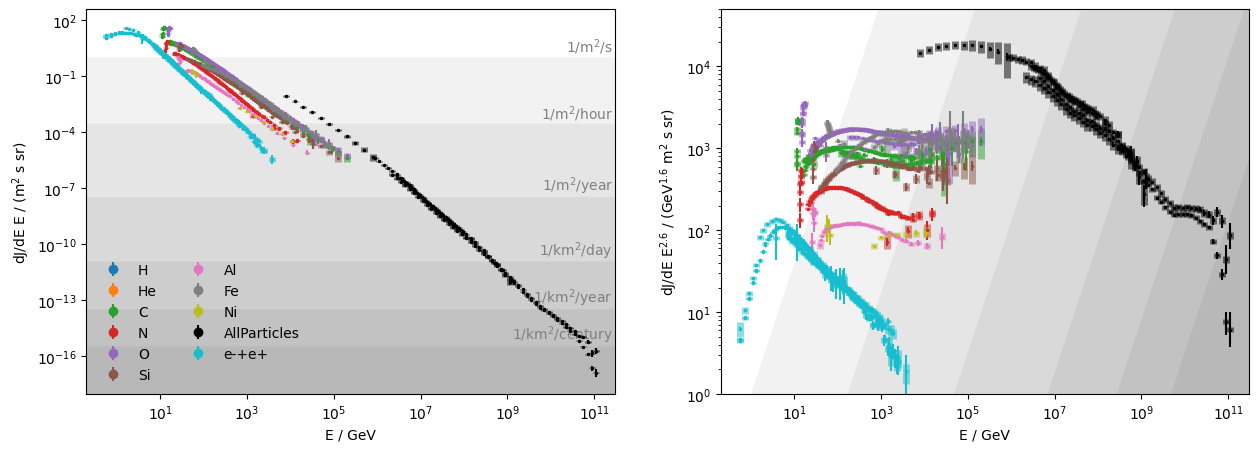

In [236]:
from matplotlib import colormaps
import re

cm = colormaps["turbo"]

elements = ("H", "He", "C", "N", "O", "Si", "Al", "Fe", "Ni")
other = "AllParticles", "e-+e+"
nelem = len(elements)

exponents = (1, 2.6)

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
for exponent, axi in zip(exponents, ax):
    plt.sca(axi)
    for ielem, elem in enumerate(elements + other):
        tab = crdb.query(elem, energy_type="ETOT", energy_convert_level=2)
        sta = np.row_stack([np.abs(tab["err_stat_minus"]), tab["err_stat_plus"]])
        sys = np.row_stack([np.abs(tab["err_sys_minus"]), tab["err_sys_plus"]])
        with np.errstate(divide="ignore"):
            mask = (sta[0] > 0) & (sys[0] > 0) & (sta[0] / tab["value"] < 0.5)
        t = tab[mask]
        x = t["e_mean"]
        y = t["value"]
        f = x ** exponent
        sta = np.row_stack([np.abs(t["err_stat_minus"]), t["err_stat_plus"]])
        sys = np.row_stack([np.abs(t["err_sys_minus"]), t["err_sys_plus"]])
        if ielem < nelem:
            color = f"C{ielem}"
        else:
            color = ("k", f"C{nelem}")[ielem - nelem]
        plt.errorbar(x, y * f, sta * f,
                    fmt=".", ms=3, color=color, label=elem)
        plt.errorbar(x, y * f, sys * f,
                    color="none", ecolor=color, lw=5, alpha=0.5)
        if exponent == 1:
            plt.ylabel(f"dJ/dE E / (m$^2$ s sr)")
        else:
            plt.ylabel(f"dJ/dE E$^{{{exponent}}}$ / (GeV$^{{{exponent - 1}}}$ m$^2$ s sr)")

m = 1
km = 1e3 * m
s = 1
hour = 60 ** 2 * s
day = 24 * hour
year = 356 * day
century = 100 * year
x = np.geomspace(2e-1, 3e11, 1000)
for exponent, axi in zip(exponents, ax):
    axi.loglog();
    axi.set_xlabel("E / GeV")
    axi.set_xlim(x[0], x[-1])
    for flux_ref in ("1/m^2/s", "1/m^2/hour", "1/m^2/year", "1/km^2/day", "1/km^2/year", "1/km^2/century"):
        code = flux_ref.replace("^", "**")
        label = re.sub(r"\^(.)", r"$^{\1}$", flux_ref)
        v = eval(code)
        y = v * x ** (exponent - 1)
        axi.fill_between(x, y, color="k", zorder=0, alpha=0.05, lw=0)
        if axi is ax[0]:
            axi.text(x[-1] * 0.9, y[-1] * 1.1, label, va="bottom", ha="right", color="0.5",
                     zorder=0)

ax[0].legend(frameon=False, ncol=2, loc="lower left", markerscale=4)
ax[1].set_ylim(1, 5e4)

## Cosmic ray composition

ValueError: <html><body><p>The quantity H-group does not exist</p></body></html>

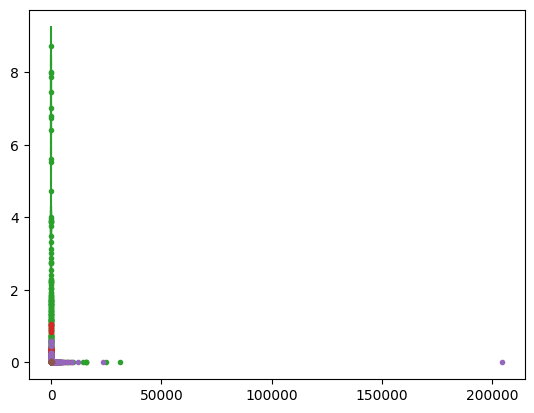

In [5]:
for ielem, elem in enumerate(("H", "He", "O", "Si", "Fe", "Ni", "H-group", "He-group", "O-group", "Fe-group")):
    tab = crdb.query(elem, energy_type="R", energy_convert_level=2)
    sta = np.row_stack([np.abs(tab["err_stat_minus"]), tab["err_stat_plus"]])
    sys = np.row_stack([np.abs(tab["err_sys_minus"]), tab["err_sys_plus"]])
    plt.errorbar(tab["e_mean"], tab["value"], sta,
                 fmt=".", color=f"C{ielem}", label=elem)
plt.xlabel("R / GV")
plt.ylabel("dJ/dR R$^2$")
plt.legend()
plt.loglog();